# Data Sufficiency and Selection

In this notebook we will be covering the following

- Feature Importance
- Single Factor Analysis
- Learning Curves

In [1]:
# all imports at the top!
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import (
    SelectFromModel, 
    SelectKBest, 
    mutual_info_classif,
    chi2,
    f_classif
)
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import learning_curve
from IPython.display import Image

In [2]:
df = pd.read_csv('data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Single Factor Analysis on Categoricals



## nunique

count how many unique values exist for a categorical

In [3]:
df.Ticket.nunique()

681

In [4]:
df.PassengerId.nunique()

891

## value_counts

count the occurrences of each category for a feature

In [5]:
df.Ticket.value_counts().head()

CA. 2343    7
1601        7
347082      7
3101295     6
CA 2144     6
Name: Ticket, dtype: int64

In [6]:
df.Cabin.value_counts().head()

B96 B98        4
G6             4
C23 C25 C27    4
F2             3
C22 C26        3
Name: Cabin, dtype: int64

## plot the value counts for all categoricals

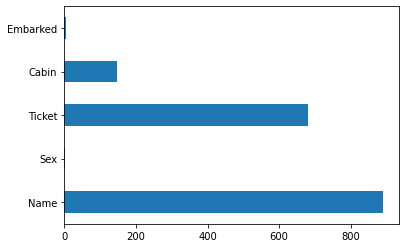

In [7]:
categorical_columns = df.select_dtypes(include='object').columns
pd.Series({
    colname: df[colname].nunique()
    for colname in categorical_columns
}, index=categorical_columns).plot.barh();

# Learning curve

Here is the function that is taken from the sklearn page on learning curves:

In [8]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test Set score")

    plt.legend(loc="best")
    return plt

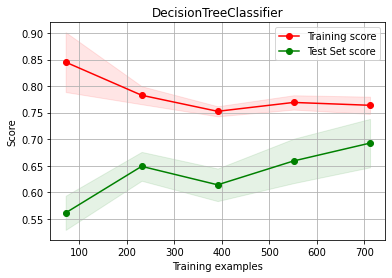

In [9]:
# and this is how we used it

X = df.select_dtypes(exclude='object').fillna(-1).drop('Survived', axis=1)
y = df.Survived

clf = DecisionTreeClassifier(random_state=1, max_depth=5)

plot_learning_curve(X=X, y=y, estimator=clf, title='DecisionTreeClassifier');

And remember the internals of what this function is actually doing by knowing how to use the
output of the scikit [learning_curve](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) function

In [10]:
# here's where the magic happens! The learning curve function is going
# to take your classifier and your training data and subset the data
train_sizes, train_scores, test_scores = learning_curve(clf, X, y)

# 5 different training set sizes have been selected
# with the smallest being 59 and the largest being 594
# the remaining is used for testing
print('train set sizes', train_sizes)
print('test set sizes', X.shape[0] - train_sizes)

train set sizes [ 71 231 391 551 712]
test set sizes [820 660 500 340 179]


In [11]:
# each row corresponds to a training set size
# each column corresponds to a cross validation fold
# the first row is the highest because it corresponds
# to the smallest training set which means that it's very
# easy for the classifier to overfit and have perfect
# test set predictions while as the test set grows it
# becomes a bit more difficult for this to happen.
train_scores

array([[0.95774648, 0.81690141, 0.81690141, 0.81690141, 0.81690141],
       [0.76190476, 0.81385281, 0.77922078, 0.77922078, 0.77922078],
       [0.74168798, 0.76726343, 0.75959079, 0.74680307, 0.74680307],
       [0.76950998, 0.78584392, 0.78039927, 0.76225045, 0.7477314 ],
       [0.77247191, 0.78792135, 0.75842697, 0.76123596, 0.73876404]])

In [12]:
# The test set scores where again, each row corresponds
# to a train / test set size and each column is a differet
# run with the same train / test sizes
test_scores

array([[0.61452514, 0.54494382, 0.57865169, 0.54494382, 0.52247191],
       [0.62011173, 0.61235955, 0.67977528, 0.66853933, 0.66292135],
       [0.60335196, 0.56179775, 0.61797753, 0.63483146, 0.65168539],
       [0.60335196, 0.62921348, 0.67977528, 0.65730337, 0.7247191 ],
       [0.65363128, 0.62359551, 0.7247191 , 0.74157303, 0.71910112]])

In [13]:
# Let's average the scores across each fold so that we can plot them
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

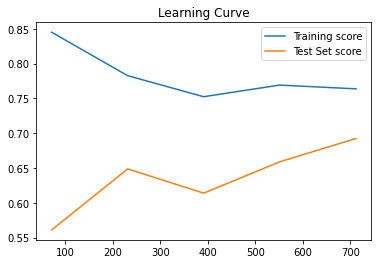

In [14]:
# this one isn't quite as cool as the other because it doesn't show the variance
# but the fundamentals are still here and it's a much simpler one to understand

learning_curve_df = pd.DataFrame({
    'Training score': train_scores_mean,
    'Test Set score': test_scores_mean
}, index=train_sizes)

learning_curve_df.plot.line(title='Learning Curve');

# Feature importance

Using any tree-based estimator, you can get feature importances on a model that has already been fitted

In [15]:
# model must be fitted
clf.fit(X, y)
feature_importances = clf.feature_importances_

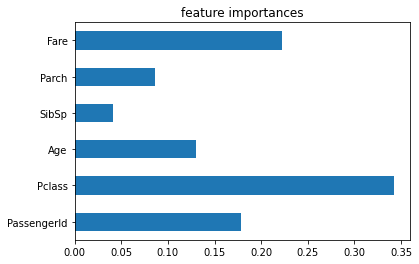

In [16]:
# now you can plot the importances by creating a pandas Series with the correct index

pd.Series(clf.feature_importances_, index=X.columns).plot.barh(title='feature importances');

# Feature importance

Using linear models that fit coefficients

/Users/pedrofonseca/.virtualenv/new/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


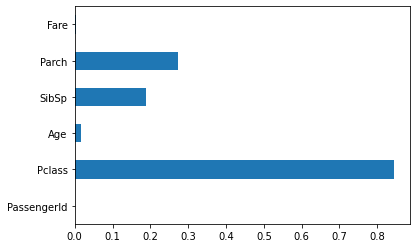

In [17]:
clf = LogisticRegression(random_state=1, solver='lbfgs')
clf.fit(X, y)
abs_coefs = pd.Series(clf.coef_[0, :], index=X.columns).abs()
abs_coefs.plot.barh();

## Correlations

Computing correlations is pure pandas. Remember that there are a few

In [18]:
X.corr()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.035144,0.037997,-0.057527,-0.001652,0.012658
Pclass,-0.035144,1.000000,-0.359728,0.083081,0.018443,-0.549500
Age,0.037997,-0.359728,1.000000,-0.182282,-0.045272,0.135707
SibSp,-0.057527,0.083081,-0.182282,1.000000,0.414838,0.159651
Parch,-0.001652,0.018443,-0.045272,0.414838,1.000000,0.216225
Fare,0.012658,-0.549500,0.135707,0.159651,0.216225,1.000000


## SelectFromModel

Using a previously trained model that is either a linear or tree-based model, we can select use SelectFromModel to select the top k features without having to know which type it is.

In [19]:
clf_linear = LogisticRegression(random_state=1, solver='lbfgs')
clf_linear.fit(X, y);

/Users/pedrofonseca/.virtualenv/new/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [20]:
clf_tree = DecisionTreeClassifier(random_state=1, max_depth=5)
clf_tree.fit(X, y);

In [21]:
def select_from_model(clf, X_train):
    sfm = SelectFromModel(clf, prefit=True, max_features=4)
    selected_features = X_train.columns[sfm.get_support()]
    return list(selected_features)

In [22]:
select_from_model(clf_linear, X)

['Pclass', 'Parch']

In [23]:
select_from_model(clf_tree, X)

['PassengerId', 'Pclass', 'Fare']

## SelectKBest

Using functions that take measures between individual features and the target column, you can also select the k with the highest scores

In [24]:
def select_k_best(method, X, y, k=4):
    skb = SelectKBest(method, k=k)
    skb.fit(X, y)
    if method is not mutual_info_classif:
        p_values = skb.pvalues_.round(4)
    else:
        p_values = None
    result = pd.DataFrame({
        'column': X.columns, 
        'p_values': p_values, 
        'scores': skb.scores_,
        'selected': skb.get_support()
    }).sort_values(by='scores', ascending=False)
    return result

In [25]:
select_k_best(mutual_info_classif, X, y)

,column,p_values,scores,selected
5,Fare,None,0.141294,True
1,Pclass,None,0.049321,True
0,PassengerId,None,0.018010,True
2,Age,None,0.014748,True
4,Parch,None,0.003097,False
3,SibSp,None,0.002260,False


In [26]:
# chi2 cannot handle negative numbers so quick hack to make them all positive
# DON'T DO THIS BLINDLY! THIS IS JUST A HACK FOR DEMONSTRATION PURPOSES!
select_k_best(chi2, X.abs(), y)

,column,p_values,scores,selected
5,Fare,0.0000,4518.319091,True
1,Pclass,0.0000,30.873699,True
4,Parch,0.0015,10.097499,True
0,PassengerId,0.0687,3.312934,True
3,SibSp,0.1081,2.581865,False
2,Age,0.3654,0.819417,False


In [27]:
select_k_best(f_classif, X, y)

,column,p_values,scores,selected
1,Pclass,0.0000,115.031272,True
5,Fare,0.0000,63.030764,True
4,Parch,0.0148,5.963464,True
3,SibSp,0.2922,1.110572,True
2,Age,0.7108,0.137576,False
0,PassengerId,0.8814,0.022285,False
